### **Andamento do Projeto Paper Model - Junho/22**

### **Relembrando...**

A ideia foi utilizar heurísticas do problema de Bin Packing 2d com retângulos para encaixar as peças do paper model em uma folha A4.

Utilizando o algoritmo de Maximal Rectangles com heurística de bottom-left como critério para encaixar as peças, fomos capaz de encaixar o modelo do Harry Potter em 3 folhas A4, conforme abaixo.


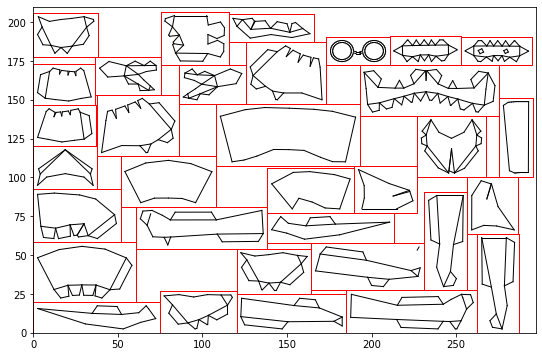

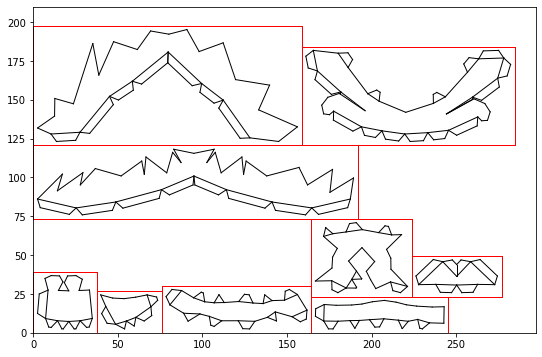

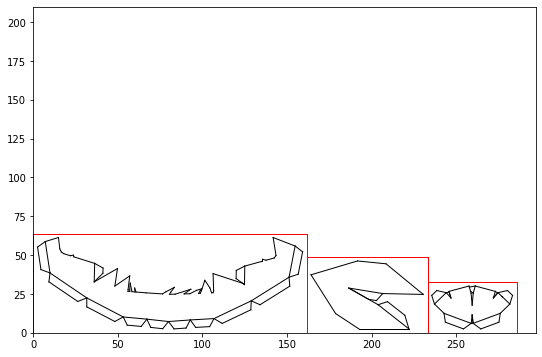

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import matplotlib.pyplot as plt
from pynest.elements.papermodel import PaperModel
from pynest.packing.bottomleft import BLPacker


# Cria modelo
data_path = f"/workspaces/paper-model-nest/pynest/data/svgs"
model = PaperModel(svg_path=f"{data_path}/harry-potter.svg")

# Algoritmo de packing
packer = BLPacker(297,210, model.bounding_rects)
packer.pack(allow_rotation=False)

# Plot
for bin in packer.bins:
    bin.plot(show_names=False)


### **Melhorias**

Motivados pelo resultado do exemplo do Harry Potter, implementamos duas metodologias para melhorar a performance do packing. Apesar de serem aplicadas somente no algoritmo de Maximal Rectangles-BL, essas melhorias são gerais, de forma que independem do algoritmo e heurística de packing escolhidos. 

##### **1) Permissão de rotações**

Nesta melhoria, permitimos rotações de 90º dos MBRs e das peças. Assim, no algoritmo Maximal Rectangles-BL, procura-se o retângulo livre cujo retângulo ou o retângulo rotacionado tem a menor altura e está mais a esquerda.

##### **2) Ordenação dos retângulos**

Nesta melhoria, ordenamos os retângulos de entrada de acordo com alguns critérios antes de produzir o packing. Implementamos os seguintes critérios de ordenação conforme apresentados em [1] para ordenar dois retângulos `Ra = (wa, ha)` e `Rb = (wb, hb)`

1. **Ordenação por área (ASCA e DESCA)**: `Ra < Rb` iff `wa * ha < wb * hb`. Esta variante é chamada de **ASCA**. Invertendo a ordem da condição, temos a variantes **DESCA**.
2. **Ordenação pelo menor lado primeiro (ASCSS e DESCSS)**: `Ra < Rb` iff  `wa < wb` ou `wa == wb` e `ha < hb`.
3. **Ordenação pelo maior lado primeiro (ASCLS e DESCLS)**: `Ra < Rb` iff `ha < hb` ou `ha == hb` e `wa < wb`.
4. **Ordenação pelo perímetro (ASCPERIM e DESCPERIM)**: `Ra < Rb` iff `wa + ha < wb + hb`.
5. **Ordenação pela dif. do tamanho dos lados (ASCDIFF e DESCDIFF)**: `Ra < Rb` iff `|wa - ha| < |wb - hb|`.
6. **Ordenação pela razão dos lados (ASCRATIO e DESCRATIO)**: `Ra < Rb` iff `wa/ha < wb/hb`

#### **Resultado com permissão de rotações:**

Podemos notar que houve um melhor encaixe das peças, permitindo que duas outras peças fossem encaixadas no segundo bin. Porém, ainda há diversos espaços vazios entre as peças, o que não permitiu reduzir o número de bins.

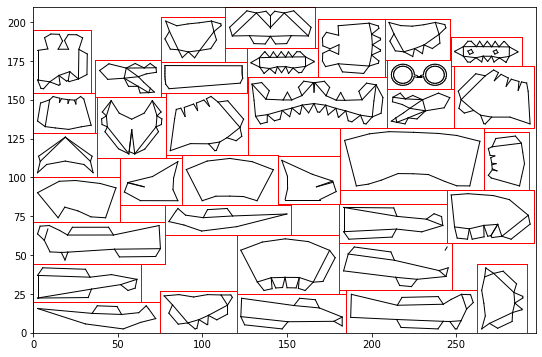

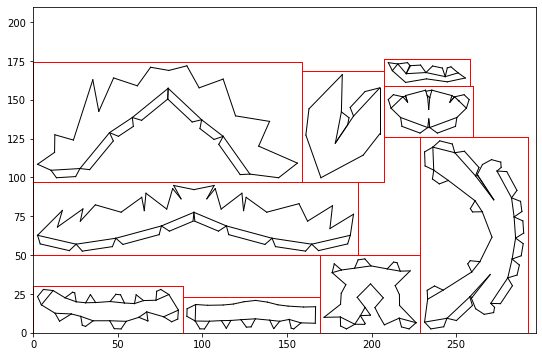

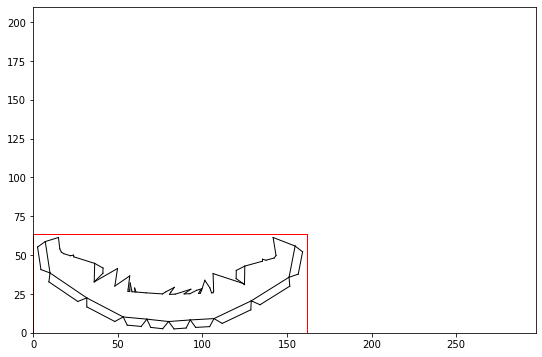

In [5]:
model = PaperModel(svg_path=f"{data_path}/harry-potter.svg")

packer = BLPacker(297,210, model.bounding_rects)
packer.pack(allow_rotation=True) ## Permite rotações

for bin in packer.bins:
    bin.plot(show_names=False)

#### **Resultado permitindo rotações e ordenação:**

Para encontrar o melhor critério de ordenação, rodamos o algoritmo de packing proposto com todos os critérios apresentados e escolhemos aquele que produziu o menor número de bins. No caso de mais de um critério produzir o número mínimo de bins, desempatamos escolhendo aquele que deixa a maior área livre no último bin.

Utilizando o critério DESCLS, foi possível produzir um encaixe das peças do modelo em apenas 2 bins. Note que ao aplicarmos qualquer um dos critérios de ordenação propostos, abrimos mão do requisito de peças de um mesmo grupo estarem próximas.

In [9]:
from pynest.packing.bottomleft import BLPacker
from pynest.packing.sorter import SortMethod

sort_methods = [
    SortMethod.ASCA,
    SortMethod.DESCA,
    SortMethod.ASCSS,
    SortMethod.DESCSS,
    SortMethod.ASCLS,
    SortMethod.DESCLS,
    SortMethod.ASCRATIO,
    SortMethod.DESCRATIO,
    SortMethod.ASCDIFF,
    SortMethod.DESCDIFF,
    SortMethod.ASCPERIM,
    SortMethod.DESCPERIM
]

best_method = None
min_bins = 100000000000
free_area = 10000000000
best_packer = None

for method in sort_methods:
    model = PaperModel(svg_path=f"{data_path}/harry-potter.svg")
    packer = BLPacker(297,210, model.bounding_rects)
    packer.pack(allow_rotation=True, sort_by=method) # Adiciona método de ordenação

    if len(packer.bins) < min_bins:
        best_method = method
        min_bins = len(packer.bins)
        free_area = packer.bins[-1].free_area
        best_packer = packer

    elif len(packer.bins) == min_bins:
        if packer.bins[-1].free_area > free_area:
            best_method = method
            free_area = packer.bins[-1].free_area
            best_packer = packer

print(f"Melhor método: {best_method}")

for bin in best_packer.bins:
    bin.plot(show_names=False)

### **Próximos passos**

- Verificar resultados para o modelo e190-e2 e entender se em cima desse há mais melhorias que podem ser implementadas.
- Conversão das peças para SVG.


### **Referências**

- [1] Jukka Jylang - A Thousand Ways to Pack the Bin - A Practical Approach to Two-Dimensional Rectangle Bin Packing (2010)
- [2] Rectpack repository: https://github.com/secnot/rectpack
- [3] Greedypacker repository: https://github.com/solomon-b/greedypacker